In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import scipy.stats as stats
from sklearn import cluster, metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
file_location = 'C:\\fx_2017_19.csv'

In [4]:
f = pd.read_csv(file_location)
df = pd.DataFrame(f)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 781 non-null    object 
 1   USTWBGD Index  (R1)  746 non-null    float64
 2   MXWD Index  (R1)     781 non-null    float64
 3   CO1 Comdty  (R1)     773 non-null    float64
 4   CNY Curncy  (R2)     731 non-null    float64
 5   TWD Curncy  (L2)     736 non-null    float64
 6   KRW Curncy  (R1)     733 non-null    float64
 7   SGD Curncy  (R1)     781 non-null    float64
 8   MYR Curncy  (L1)     730 non-null    float64
 9   IDR Curncy  (R1)     724 non-null    float64
 10  THB Curncy  (L3)     733 non-null    float64
 11  PHP Curncy  (R3)     728 non-null    float64
 12  INR Curncy  (R4)     723 non-null    float64
 13  RUB Curncy  (R3)     757 non-null    float64
 14  PLN Curncy  (R1)     781 non-null    float64
 15  HUF Curncy  (L3)     781 non-null    flo

In [6]:
df['Date'] = pd.to_datetime(df.Date).dt.to_period('D')

In [7]:
df.set_index('Date', inplace=True)
df.index = df.index.to_timestamp()

In [8]:
df.columns = ['usd', 'msci', 'oil', 'cny', 'twd', 'krw', 'sgd', 'myr', 'idr', 'thb', 'php', 'inr', 'rub', 
                'pln', 'huf', 'ron', 'try', 'brl', 'mxn', 'clp', 'cop', 'zar', 'ils', 'eur', 'gbp',
                'jpy', 'aud', 'nzd', 'cad', 'chf', 'nok', 'sek', 'gold', 'silver']

In [9]:
df.head(5)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,gold,silver
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,115.0184,564.38,68.44,6.9868,30.074,1156.25,1.3484,4.1070,13925.0,29.967,...,0.7622,108.89,1.4285,1.4856,1.3060,0.9681,8.7997,9.3264,1515.2000,17.9423
2019-12-27,115.2705,566.84,68.16,6.9957,30.141,1161.40,1.3523,4.1272,13952.0,30.150,...,0.7645,109.44,1.4327,1.4926,1.3079,0.9750,8.8148,9.3366,1510.5601,17.7675
2019-12-26,115.6713,565.45,67.92,6.9965,30.152,1161.95,1.3540,4.1337,13958.0,30.170,...,0.7687,109.63,1.4410,1.4997,1.3118,0.9808,8.8731,9.4066,1508.7000,17.8742
2019-12-25,NaN,563.38,NaN,6.9894,30.142,NaN,1.3550,NaN,NaN,30.167,...,0.7721,109.35,1.4450,1.5076,1.3157,0.9805,8.9093,9.4125,1499.8400,17.7790
2019-12-24,115.8267,563.50,67.20,7.0073,30.170,1163.80,1.3549,4.1363,NaN,30.160,...,0.7710,109.41,1.4444,1.5042,1.3158,0.9800,8.9094,9.4073,1499.7300,17.7540


# Feature Engineering

#### All the exchange rates are rendered in USD/XXX terms, so they are all expressed as 1 US dollar equivalents. 
#### The broad USD index used is the Fed nominal broad trade-weighted US dollar exchange rate, and the crude oil price is the Brent crude price.

In [10]:
# Generate the equivalent 1 US$ values for gold and silver
df['au$'] = 1/df.gold
df['ag$'] = 1/df.silver

In [11]:
df.drop(['gold', 'silver'], axis=1, inplace=True)

In [12]:
df.head(5)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,115.0184,564.38,68.44,6.9868,30.074,1156.25,1.3484,4.1070,13925.0,29.967,...,0.7622,108.89,1.4285,1.4856,1.3060,0.9681,8.7997,9.3264,0.000660,0.055734
2019-12-27,115.2705,566.84,68.16,6.9957,30.141,1161.40,1.3523,4.1272,13952.0,30.150,...,0.7645,109.44,1.4327,1.4926,1.3079,0.9750,8.8148,9.3366,0.000662,0.056283
2019-12-26,115.6713,565.45,67.92,6.9965,30.152,1161.95,1.3540,4.1337,13958.0,30.170,...,0.7687,109.63,1.4410,1.4997,1.3118,0.9808,8.8731,9.4066,0.000663,0.055947
2019-12-25,NaN,563.38,NaN,6.9894,30.142,NaN,1.3550,NaN,NaN,30.167,...,0.7721,109.35,1.4450,1.5076,1.3157,0.9805,8.9093,9.4125,0.000667,0.056246
2019-12-24,115.8267,563.50,67.20,7.0073,30.170,1163.80,1.3549,4.1363,NaN,30.160,...,0.7710,109.41,1.4444,1.5042,1.3158,0.9800,8.9094,9.4073,0.000667,0.056325


#### Dealing with financial market returns correlations, it is preferable to use the log returns, but the CAPM beta is calculated on the simple percentage returns. 

#### Furthermore, it is preferable to standardise the data for the clustering algorithms.

#### Thus, the order of data transformation will be to obtain the log returns and calculate the correlation coefficients, then get the simple returns and calculate the betas, and finally standardise the data. 

## Calculate cross-asset correlations

#### Correlations are a linear measure, so we use the log returns to reduce the likely distributional skew to FX returns, though FX returns do tend to be less skewed than equities. But we check later below.

In [13]:
df_logret = np.log(df/df.shift())

In [14]:
df_logret

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,0.002189,0.004349,-0.004100,0.001273,0.002225,0.004444,0.002888,0.004906,0.001937,0.006088,...,0.003013,0.005038,0.002936,0.004701,0.001454,0.007102,0.001714,0.001093,0.003067,0.009790
2019-12-26,0.003471,-0.002455,-0.003527,0.000114,0.000365,0.000473,0.001256,0.001574,0.000430,0.000663,...,0.005479,0.001735,0.005777,0.004746,0.002977,0.005931,0.006592,0.007469,0.001232,-0.005987
2019-12-25,NaN,-0.003668,NaN,-0.001015,-0.000332,NaN,0.000738,NaN,NaN,-0.000099,...,0.004413,-0.002557,0.002772,0.005254,0.002969,-0.000306,0.004071,0.000627,0.005890,0.005340
2019-12-24,NaN,0.000213,NaN,0.002558,0.000929,NaN,-0.000074,NaN,NaN,-0.000232,...,-0.001426,0.000549,-0.000415,-0.002258,0.000076,-0.000510,0.000011,-0.000553,0.000073,0.001407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,-0.002950,-0.000256,-0.003685,-0.007158,-0.000845,-0.005674,-0.007393,0.002969,0.000748,0.002687,...,-0.010745,-0.013854,-0.005342,-0.009859,-0.001058,-0.007494,-0.005261,-0.006324,-0.008035,-0.009301
2017-01-04,0.007414,-0.005509,-0.007587,0.008341,0.009282,0.016819,0.008713,0.002605,0.004848,0.001061,...,0.008285,0.016926,0.009275,0.011528,0.005731,0.012100,0.012706,0.012027,0.014554,0.010199
2017-01-03,0.001735,-0.008462,-0.017690,0.004288,-0.000465,-0.002598,0.004777,-0.000823,0.002972,NaN,...,0.004424,0.000511,0.004497,0.001111,0.009653,0.002539,0.004963,0.004425,0.002492,0.005935


In [15]:
# Delete the frist row of null values
df_logret = df_logret.iloc[1:]

In [16]:
correlations = df_logret.corr()

In [17]:
correlations.head(10)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
usd,1.000000,-0.380965,-0.185477,0.622516,0.338735,0.326834,0.786231,0.421665,0.434950,0.445772,...,0.488218,0.324627,0.660487,0.559814,0.638626,0.518219,0.678263,0.641744,0.483529,0.464720
msci,-0.380965,1.000000,0.296027,-0.286678,-0.310927,-0.348665,-0.326680,-0.295285,-0.363759,-0.239150,...,-0.170419,0.279932,-0.390667,-0.242587,-0.333822,0.053603,-0.349874,-0.272783,0.069403,-0.087627
oil,-0.185477,0.296027,1.000000,-0.170349,-0.065481,-0.065215,-0.135046,-0.126597,-0.080135,-0.059626,...,-0.053494,0.061643,-0.158127,-0.072037,-0.316775,0.010184,-0.295144,-0.096512,-0.049900,-0.096602
cny,0.622516,-0.286678,-0.170349,1.000000,0.383553,0.342374,0.580524,0.432812,0.357905,0.411424,...,0.276675,0.158669,0.417866,0.338075,0.309356,0.245410,0.382266,0.395783,0.366260,0.407529
twd,0.338735,-0.310927,-0.065481,0.383553,1.000000,0.740288,0.342928,0.527299,0.496441,0.463497,...,0.119332,0.058828,0.211516,0.136617,0.118539,0.107856,0.224373,0.181833,0.119866,0.153374
krw,0.326834,-0.348665,-0.065215,0.342374,0.740288,1.000000,0.336715,0.522848,0.507152,0.409384,...,0.123168,0.002651,0.235107,0.122195,0.162703,0.093605,0.216676,0.176727,0.091629,0.138953
sgd,0.786231,-0.326680,-0.135046,0.580524,0.342928,0.336715,1.000000,0.416767,0.372417,0.452083,...,0.464599,0.421064,0.702292,0.635391,0.536883,0.509134,0.656672,0.607805,0.516893,0.473860
myr,0.421665,-0.295285,-0.126597,0.432812,0.527299,0.522848,0.416767,1.000000,0.551359,0.468085,...,0.184385,0.091034,0.263812,0.204575,0.207272,0.251663,0.288404,0.269403,0.186710,0.155163
idr,0.434950,-0.363759,-0.080135,0.357905,0.496441,0.507152,0.372417,0.551359,1.000000,0.436319,...,0.166055,0.042619,0.315674,0.262605,0.258372,0.154713,0.246679,0.220293,0.129542,0.132394
thb,0.445772,-0.239150,-0.059626,0.411424,0.463497,0.409384,0.452083,0.468085,0.436319,1.000000,...,0.189979,0.170535,0.319979,0.298557,0.252925,0.222311,0.296786,0.301269,0.308719,0.284641


In [18]:
usd_correlations = correlations['usd'].iloc[3:]

In [19]:
# Array of USD correlations
usd_correlations

cny    0.622516
twd    0.338735
krw    0.326834
sgd    0.786231
myr    0.421665
idr    0.434950
thb    0.445772
php    0.247036
inr    0.377638
rub    0.436196
pln    0.746803
huf    0.724142
ron    0.679466
try    0.363348
brl    0.345944
mxn    0.618492
clp    0.578741
cop    0.611556
zar    0.583523
ils    0.395561
eur    0.702564
gbp    0.488218
jpy    0.324627
aud    0.660487
nzd    0.559814
cad    0.638626
chf    0.518219
nok    0.678263
sek    0.641744
au$    0.483529
ag$    0.464720
Name: usd, dtype: float64

In [20]:
equity_correlations = correlations['msci'].iloc[3:]

In [21]:
# Array of World equity correlations
equity_correlations

cny   -0.286678
twd   -0.310927
krw   -0.348665
sgd   -0.326680
myr   -0.295285
idr   -0.363759
thb   -0.239150
php   -0.193873
inr   -0.212306
rub   -0.321873
pln   -0.261663
huf   -0.216165
ron   -0.142674
try   -0.199519
brl   -0.230597
mxn   -0.307921
clp   -0.358394
cop   -0.428845
zar   -0.402475
ils   -0.275318
eur   -0.140400
gbp   -0.170419
jpy    0.279932
aud   -0.390667
nzd   -0.242587
cad   -0.333822
chf    0.053603
nok   -0.349874
sek   -0.272783
au$    0.069403
ag$   -0.087627
Name: msci, dtype: float64

## Calculate betas

#### The CAPM beta is calculated on simple percentage returns.

In [22]:
# Generate simple percentage returns to calculate the respective betas
df_returns = df.pct_change()

In [23]:
df_returns

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,0.002192,0.004359,-0.004091,0.001274,0.002228,0.004454,0.002892,0.004918,0.001939,0.006107,...,0.003018,0.005051,0.002940,0.004712,0.001455,0.007127,0.001716,0.001094,0.003072,0.009838
2019-12-26,0.003477,-0.002452,-0.003521,0.000114,0.000365,0.000474,0.001257,0.001575,0.000430,0.000663,...,0.005494,0.001736,0.005793,0.004757,0.002982,0.005949,0.006614,0.007497,0.001233,-0.005969
2019-12-25,0.000000,-0.003661,0.000000,-0.001015,-0.000332,0.000000,0.000739,0.000000,0.000000,-0.000099,...,0.004423,-0.002554,0.002776,0.005268,0.002973,-0.000306,0.004080,0.000627,0.005907,0.005355
2019-12-24,0.001343,0.000213,-0.010601,0.002561,0.000929,0.001592,-0.000074,0.000629,0.000000,-0.000232,...,-0.001425,0.000549,-0.000415,-0.002255,0.000076,-0.000510,0.000011,-0.000552,0.000073,0.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,-0.002946,-0.000256,-0.003678,-0.007133,-0.000844,-0.005658,-0.007366,0.002974,0.000748,0.002690,...,-0.010688,-0.013758,-0.005328,-0.009811,-0.001058,-0.007466,-0.005247,-0.006304,-0.008003,-0.009258
2017-01-04,0.007441,-0.005494,-0.007558,0.008376,0.009325,0.016961,0.008751,0.002608,0.004860,0.001062,...,0.008320,0.017070,0.009318,0.011594,0.005748,0.012173,0.012787,0.012100,0.014661,0.010251
2017-01-03,0.001736,-0.008427,-0.017535,0.004298,-0.000465,-0.002595,0.004789,-0.000823,0.002976,0.000000,...,0.004433,0.000511,0.004507,0.001111,0.009700,0.002542,0.004976,0.004435,0.002495,0.005953


In [24]:
df_returns = df_returns.iloc[1:]

In [25]:
df_returns.head(5)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-27,0.002192,0.004359,-0.004091,0.001274,0.002228,0.004454,0.002892,0.004918,0.001939,0.006107,...,0.003018,0.005051,0.002940,0.004712,0.001455,0.007127,0.001716,0.001094,0.003072,0.009838
2019-12-26,0.003477,-0.002452,-0.003521,0.000114,0.000365,0.000474,0.001257,0.001575,0.000430,0.000663,...,0.005494,0.001736,0.005793,0.004757,0.002982,0.005949,0.006614,0.007497,0.001233,-0.005969
2019-12-25,0.000000,-0.003661,0.000000,-0.001015,-0.000332,0.000000,0.000739,0.000000,0.000000,-0.000099,...,0.004423,-0.002554,0.002776,0.005268,0.002973,-0.000306,0.004080,0.000627,0.005907,0.005355
2019-12-24,0.001343,0.000213,-0.010601,0.002561,0.000929,0.001592,-0.000074,0.000629,0.000000,-0.000232,...,-0.001425,0.000549,-0.000415,-0.002255,0.000076,-0.000510,0.000011,-0.000552,0.000073,0.001408
2019-12-23,0.000167,-0.000124,-0.012054,0.000785,0.000795,0.000473,0.001033,0.001547,0.001505,0.000332,...,0.002853,-0.000183,0.000554,0.002726,-0.000304,0.002041,0.004669,0.003582,0.010566,0.018735


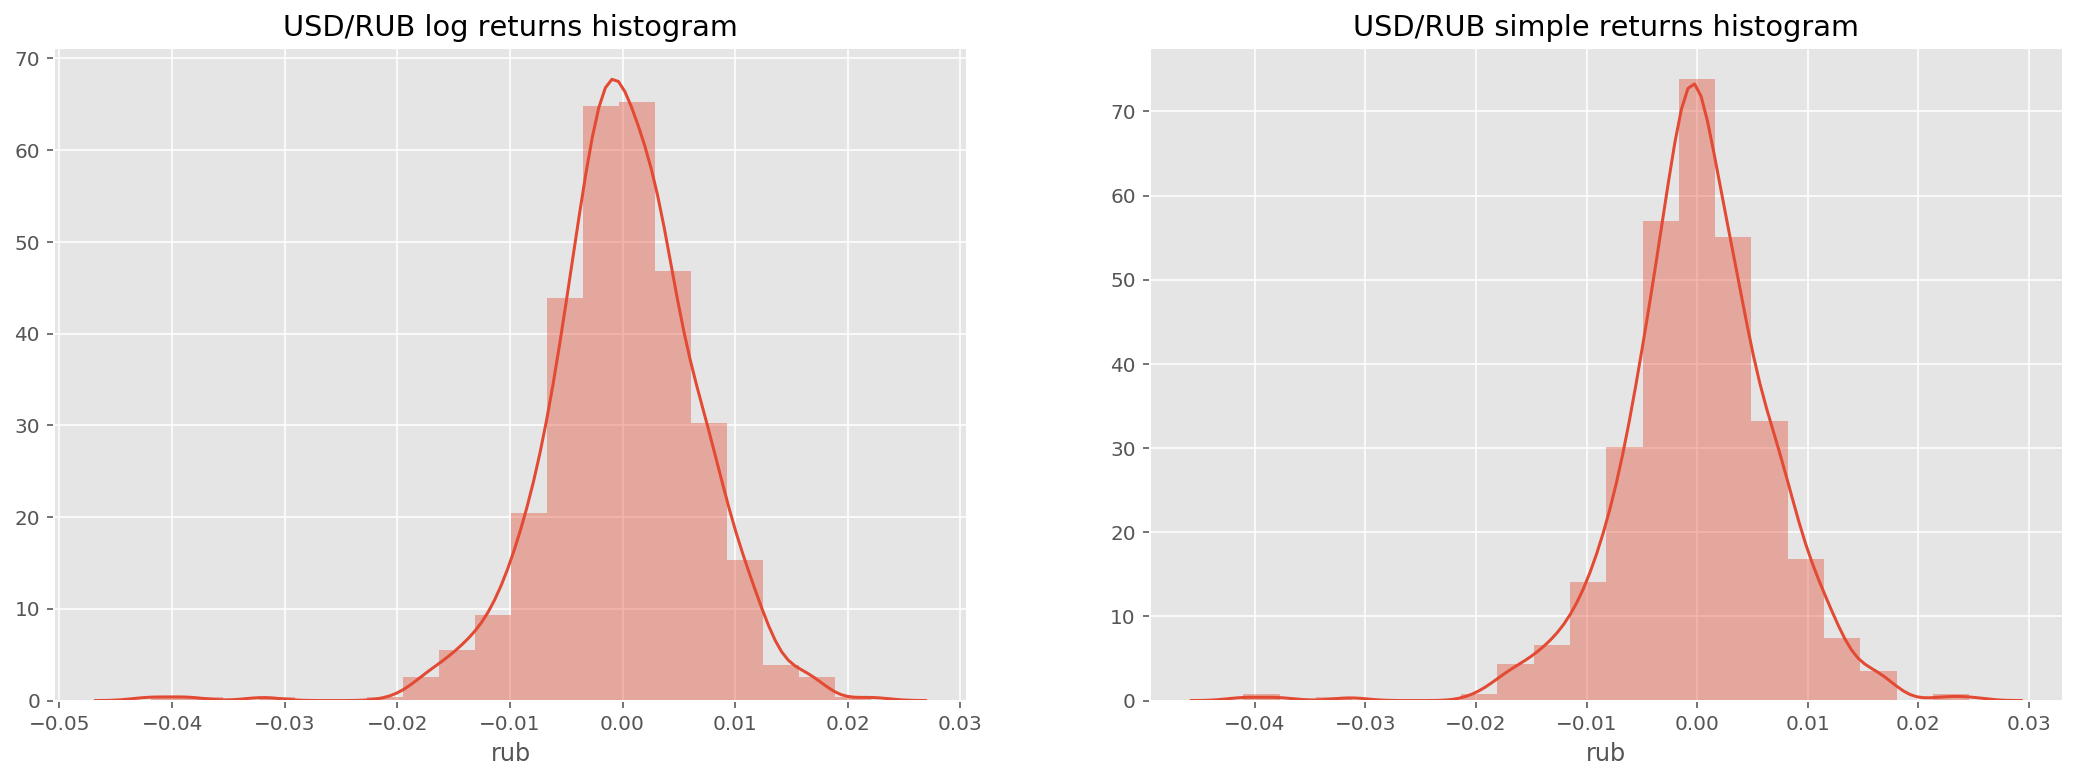

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18, 6))
sns.distplot(df_logret.rub, bins=20, kde=True, ax=ax1).set_title('USD/RUB log returns histogram')
sns.distplot(df_returns.rub, bins=20, kde=True, ax=ax2).set_title('USD/RUB simple returns histogram')
plt.show()

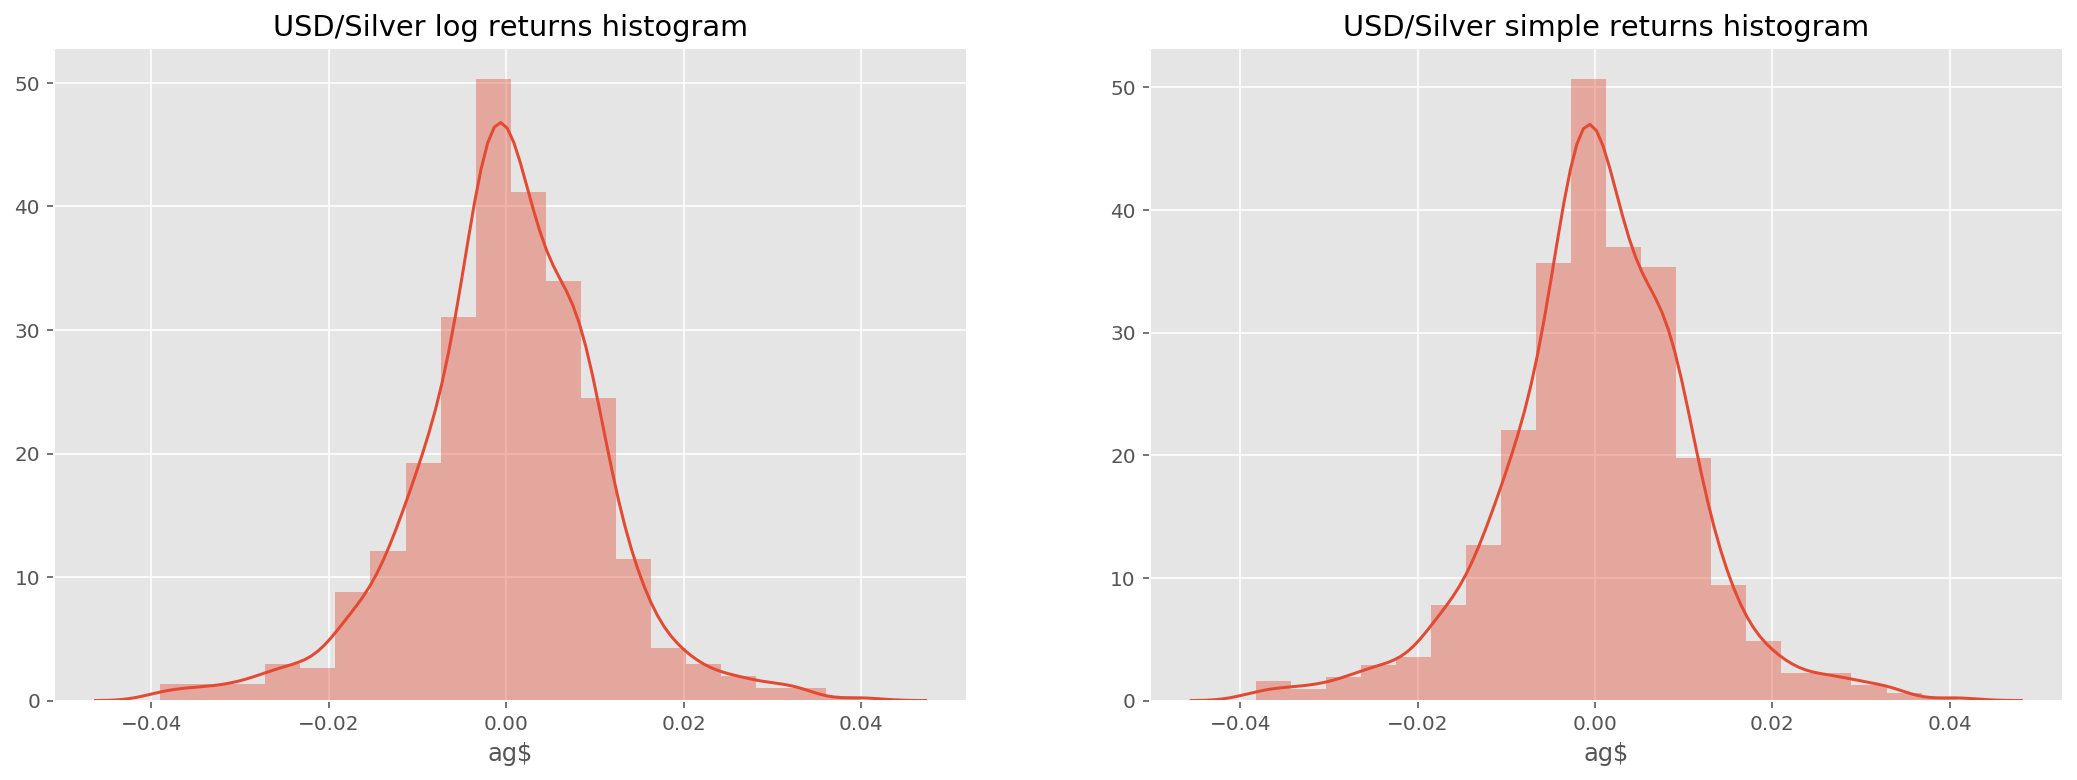

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18, 6))
sns.distplot(df_logret['ag$'], bins=20, kde=True, ax=ax1).set_title('USD/Silver log returns histogram')
sns.distplot(df_returns['ag$'], bins=20, kde=True, ax=ax2).set_title('USD/Silver simple returns histogram')
plt.show()

#### Histograms above confirm not much difference between the simple returns distribution compared to the log returns distribution, though this was in a low vol period.

In [28]:
# Function to calculate beta
def beta(df):
    # sets first column as the market data
    X = df.values[:, [0]]
    # prepend a column of ones for the intercept
    X = np.concatenate([np.ones_like(X), X], axis=1)
    # matrix algebra for regression coefficient
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, 1:])
    return pd.Series(b[1], df.columns[1:], name='beta')

In [29]:
# Calculate the betas to US dollar
usd_betas = beta(df_returns)

In [30]:
usd_betas

msci   -0.872803
oil    -1.353091
cny     0.558011
twd     0.257220
krw     0.545419
sgd     0.715111
myr     0.311994
idr     0.442703
thb     0.418545
php     0.248985
inr     0.464755
rub     1.063680
pln     1.420737
huf     1.402443
ron     1.052513
try     1.595623
brl     1.126176
mxn     1.596639
clp     1.278436
cop     1.351002
zar     2.002697
ils     0.472698
eur     1.028564
gbp     0.906211
jpy     0.542037
aud     1.166961
nzd     1.077234
cad     0.955245
chf     0.764071
nok     1.265019
sek     1.218505
au$     1.170774
ag$     1.821179
Name: beta, dtype: float64

In [31]:
del usd_betas['msci']
del usd_betas['oil']

In [32]:
usd_betas

cny    0.558011
twd    0.257220
krw    0.545419
sgd    0.715111
myr    0.311994
idr    0.442703
thb    0.418545
php    0.248985
inr    0.464755
rub    1.063680
pln    1.420737
huf    1.402443
ron    1.052513
try    1.595623
brl    1.126176
mxn    1.596639
clp    1.278436
cop    1.351002
zar    2.002697
ils    0.472698
eur    1.028564
gbp    0.906211
jpy    0.542037
aud    1.166961
nzd    1.077234
cad    0.955245
chf    0.764071
nok    1.265019
sek    1.218505
au$    1.170774
ag$    1.821179
Name: beta, dtype: float64

## Adding implied volatility

#### The values are 25-delta 3-month implied volatility

In [33]:
v = pd.read_csv('C:\\vol_2017_19.csv')

In [34]:
df_v = pd.DataFrame(v)

In [35]:
df_v['Date'] = pd.to_datetime(df_v.Date).dt.to_period('D')

In [36]:
df_v.set_index('Date', inplace=True)
df_v.index = df_v.index.to_timestamp()

In [37]:
df_v.columns = ['cny', 'twd', 'krw', 'sgd', 'myr', 'idr', 'thb', 'php', 'inr', 'rub', 
                'pln', 'huf', 'ron', 'try', 'brl', 'mxn', 'clp', 'cop', 'zar', 'ils', 'eur', 'gbp',
                'jpy', 'aud', 'nzd', 'cad', 'chf', 'nok', 'sek', 'au$', 'ag$']

In [38]:
# Forward filing all NaN values
df_v.fillna(method='ffill', inplace=True)
df_v.head(5)

,cny,twd,krw,sgd,myr,idr,thb,php,inr,rub,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,4.6050,3.7750,6.4350,2.7725,6.3825,5.1225,3.5350,4.8050,5.1900,8.2025,...,7.6150,5.3600,6.4925,7.185,4.3350,5.3450,7.8825,7.7000,11.7725,18.0900
2019-12-27,4.5025,3.7925,6.3750,2.7150,6.4225,5.1950,3.4950,4.7350,5.1800,8.1125,...,7.5250,5.1700,6.3450,7.060,4.2950,5.1500,7.6400,7.3675,11.8450,18.0725
2019-12-26,4.5250,3.8025,6.3525,2.7125,6.3875,5.0325,3.5450,4.7375,5.1700,8.0250,...,7.2650,5.0525,6.2350,6.945,4.2875,5.0375,7.5700,7.3650,11.7225,18.1775
2019-12-25,4.4700,3.7925,6.3375,2.7575,6.6075,5.0025,3.5400,4.6950,5.1525,8.0150,...,7.2275,5.0250,6.2800,6.990,4.2850,4.9950,7.5600,7.3300,10.5325,17.2150
2019-12-24,4.4700,3.7925,6.3375,2.7650,6.5775,5.0375,3.5225,4.7250,5.1850,8.0050,...,7.2200,5.0150,6.2650,6.965,4.2775,4.9950,7.5400,7.3150,10.4950,17.2250


In [39]:
vol_list = pd.DataFrame(df_v.mean(), columns=['vol'])

In [40]:
vol_list

,vol
cny,5.131818
twd,5.093537
krw,8.217590
sgd,4.431716
myr,6.743899
idr,7.122641
thb,5.130013
php,5.319555
inr,6.240227
rub,11.783409


## Consolidating all three features together

In [41]:
X = pd.DataFrame(data=[usd_betas, equity_correlations]).T

In [42]:
X = vol_list.merge(X, left_index=True, right_index=True, how='inner')

In [43]:
X.columns = ["vol", "usd_beta", "equity_corr"]

In [44]:
X = X[["usd_beta", "equity_corr", 'vol']]

# EDA

In [45]:
X

,usd_beta,equity_corr,vol
cny,0.558011,-0.286678,5.131818
twd,0.257220,-0.310927,5.093537
krw,0.545419,-0.348665,8.217590
sgd,0.715111,-0.326680,4.431716
myr,0.311994,-0.295285,6.743899
idr,0.442703,-0.363759,7.122641
thb,0.418545,-0.239150,5.130013
php,0.248985,-0.193873,5.319555
inr,0.464755,-0.212306,6.240227
rub,1.063680,-0.321873,11.783409


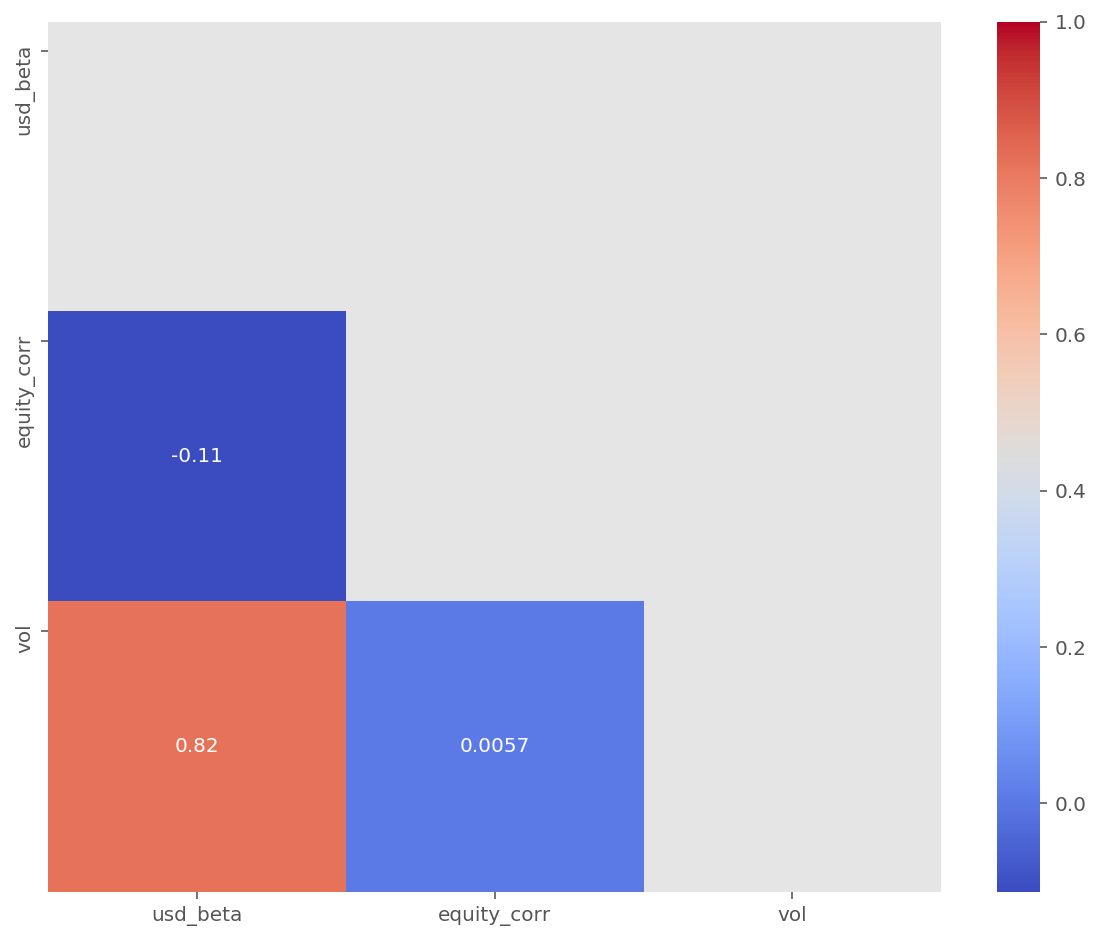

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X.corr(), mask=mask, annot=True, cmap='coolwarm', ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([X.shape[1], 0])
plt.show()

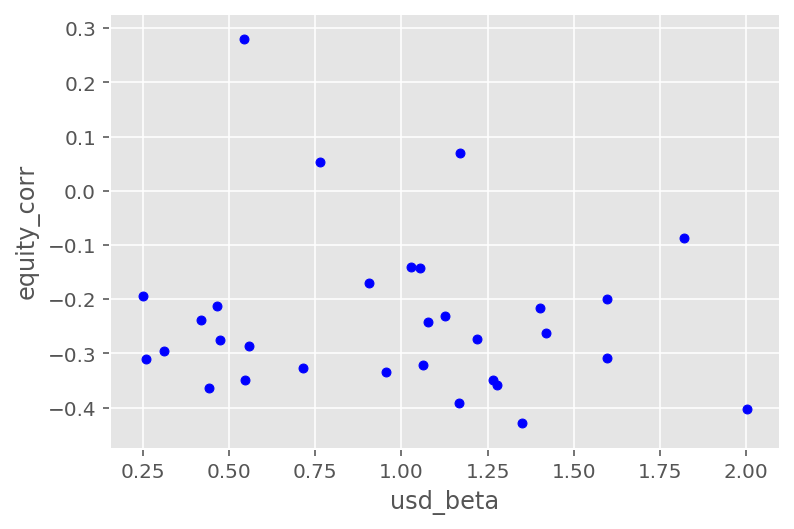

In [47]:
X.plot(kind='scatter', x='usd_beta', y='equity_corr', c='b')
plt.show()

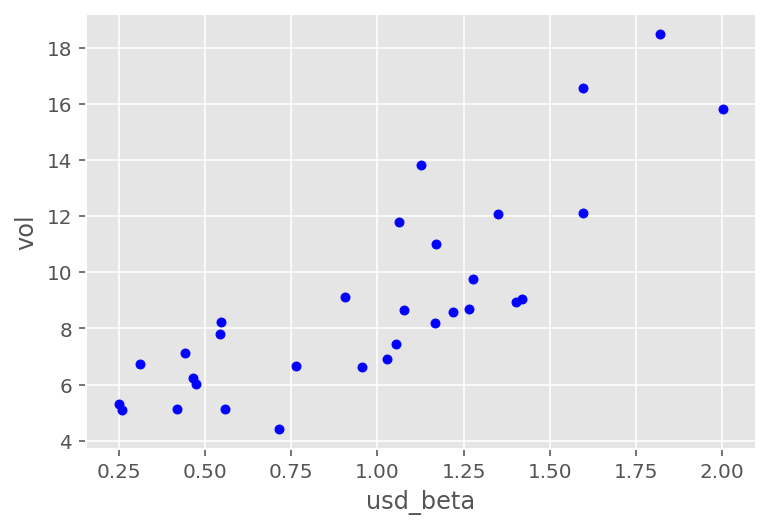

In [48]:
X.plot(kind='scatter', x='usd_beta', y='vol', c='b')
plt.show()

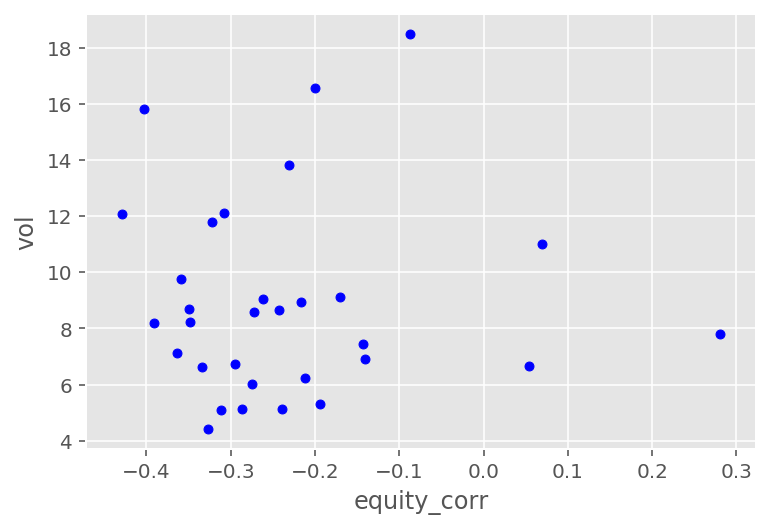

In [49]:
X.plot(kind='scatter', x='equity_corr', y='vol', c='b')
plt.show()

In [50]:
# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
X_scaled

array([[-0.89956487, -0.34315606, -1.09963823],
       [-1.54764412, -0.5065194 , -1.11065671],
       [-0.92669428, -0.76076141, -0.21145643],
       [-0.5610781 , -0.6126461 , -1.30114966],
       [-1.42962989, -0.40113935, -0.63563085],
       [-1.14800572, -0.86245003, -0.52661703],
       [-1.20005597, -0.02295681, -1.10015787],
       [-1.56538661,  0.28207175, -1.04560167],
       [-1.10049232,  0.15789174, -0.78060333],
       [ 0.18994442, -0.58025981,  0.81489825],
       [ 0.95925302, -0.17462906,  0.03002616],
       [ 0.91983899,  0.13189103, -0.00566161],
       [ 0.16588426,  0.62699942, -0.43420879],
       [ 1.33606182,  0.24403208,  2.19184055],
       [ 0.32459655,  0.03466633,  1.40517975],
       [ 1.33824983, -0.4862658 ,  0.91084763],
       [ 0.6526531 , -0.82630686,  0.23035642],
       [ 0.80900379, -1.30093391,  0.89654138],
       [ 2.21313669, -1.12327846,  1.97152978],
       [-1.08337797, -0.26662152, -0.84511293],
       [ 0.11428225,  0.64232015, -0.586

In [52]:
# Transformed the arrays of scaled values into a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [53]:
X_scaled

,usd_beta,equity_corr,vol
cny,-0.899565,-0.343156,-1.099638
twd,-1.547644,-0.506519,-1.110657
krw,-0.926694,-0.760761,-0.211456
sgd,-0.561078,-0.612646,-1.301150
myr,-1.429630,-0.401139,-0.635631
idr,-1.148006,-0.862450,-0.526617
thb,-1.200056,-0.022957,-1.100158
php,-1.565387,0.282072,-1.045602
inr,-1.100492,0.157892,-0.780603
rub,0.189944,-0.580260,0.814898


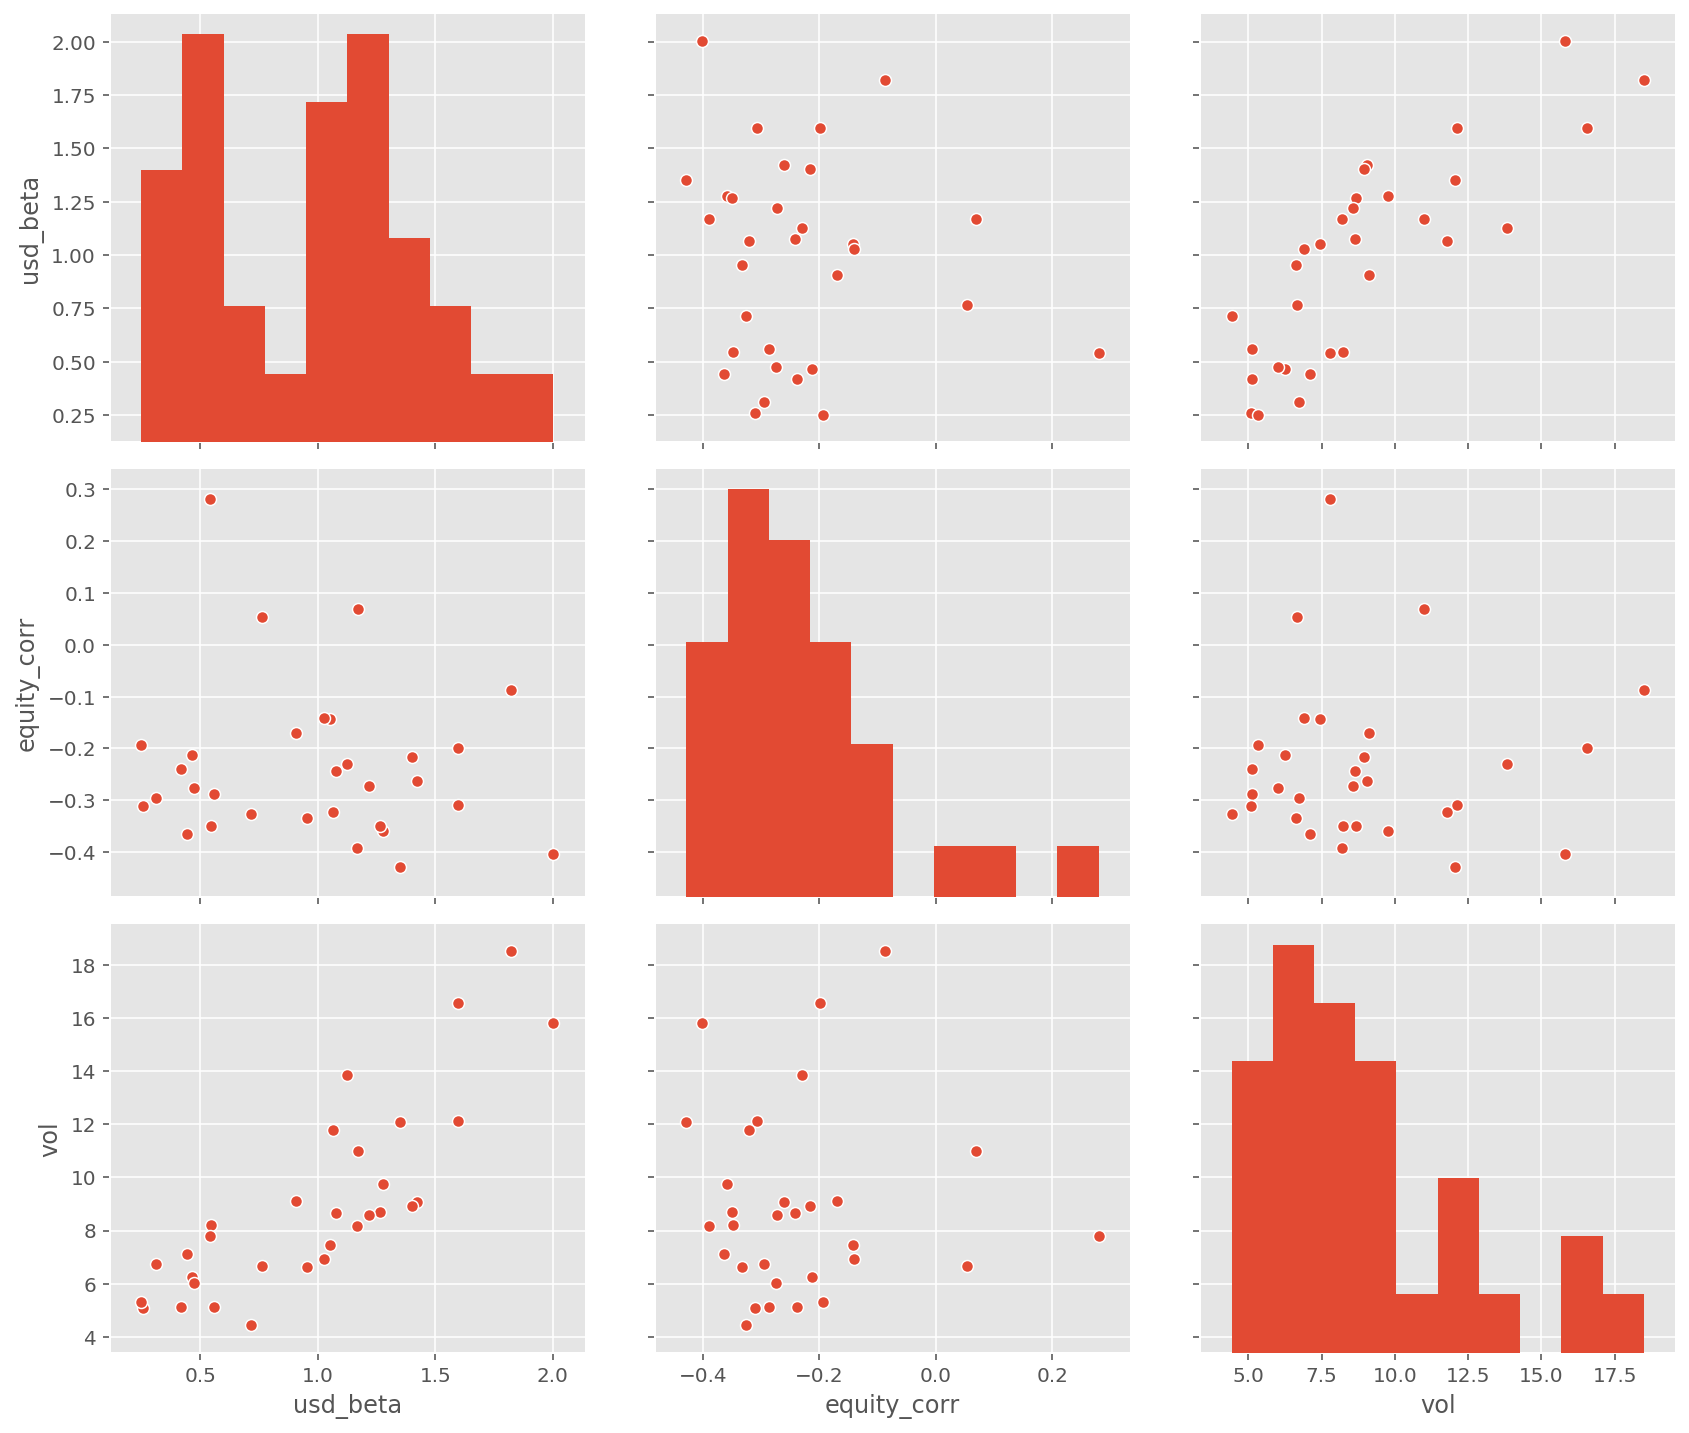

In [54]:
g=sns.pairplot(X)
g.fig.set_size_inches(12,10)
plt.show()

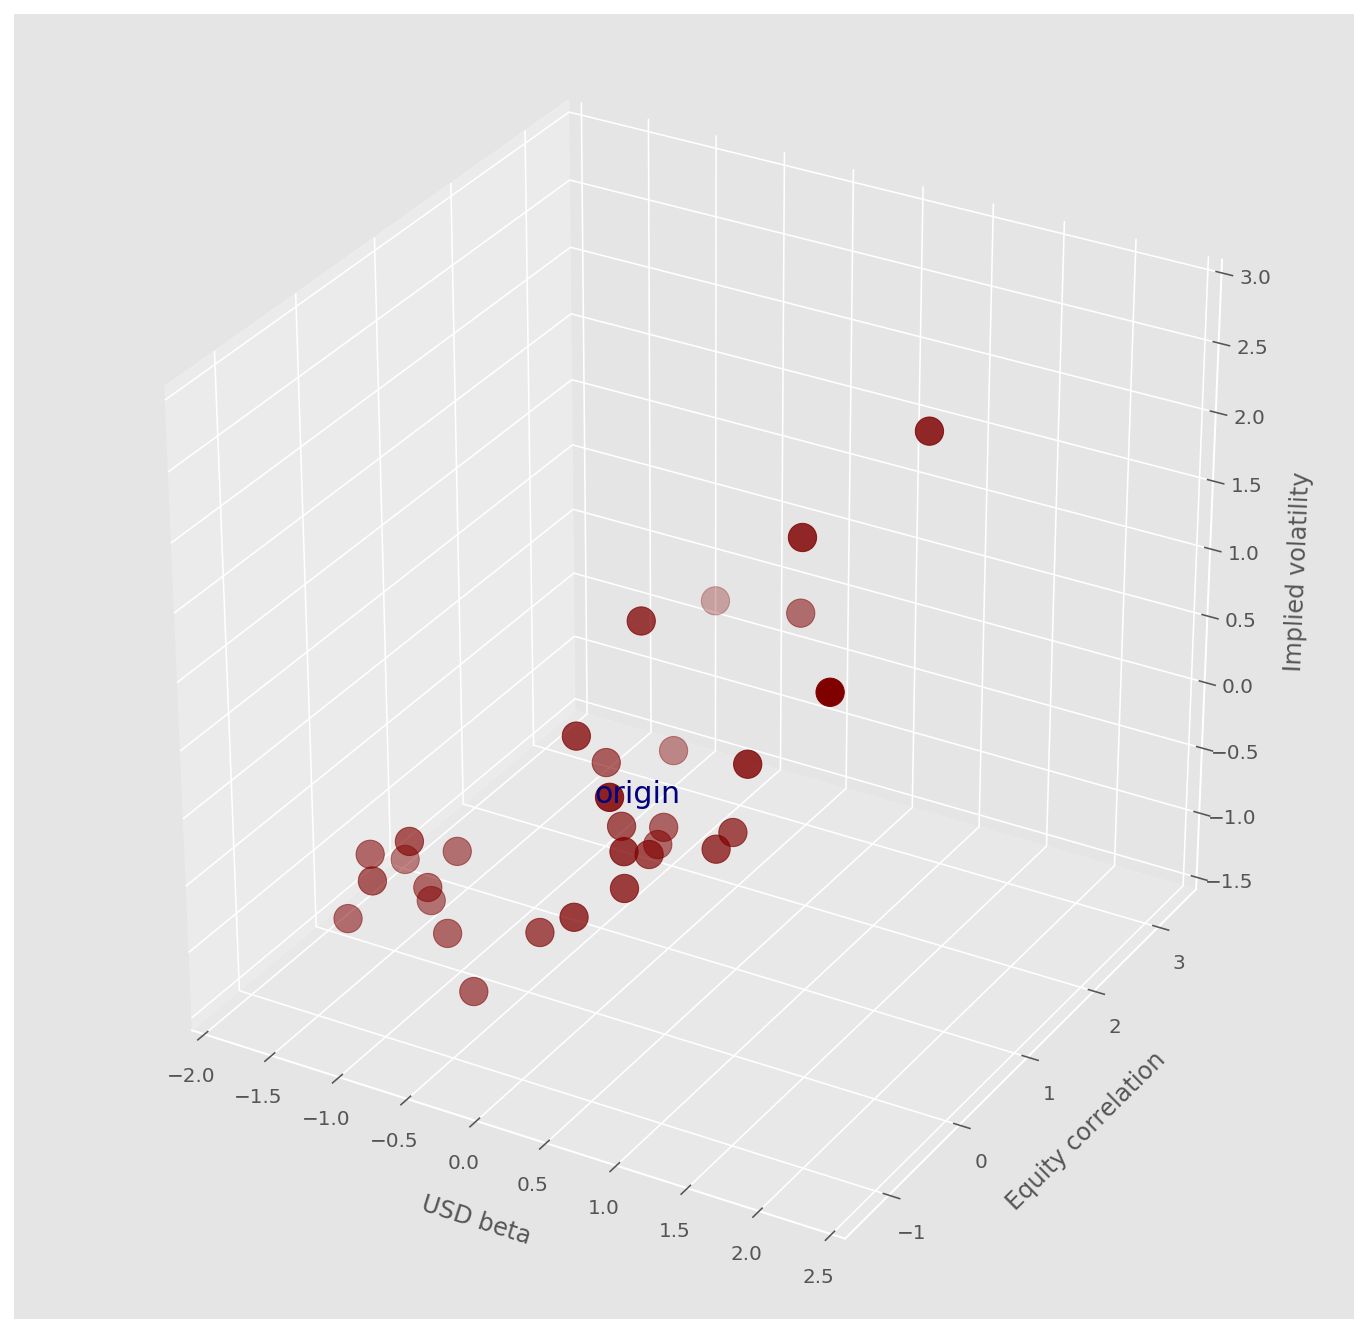

In [55]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

origin = [0,0,0]
ax.text(origin[0],origin[0],origin[0],"origin",size=15, color='navy')

x_points = X_scaled.usd_beta
y_points = X_scaled.equity_corr
z_points = X_scaled.vol
ax.scatter3D(x_points, y_points, z_points, s=200, color='maroon')

ax.set_xlim(-2, 2.5)
ax.set_ylim(-1.5, 3.5)
ax.set_zlim(-1.5, 3)

ax.set_xlabel('USD beta',labelpad=10,fontsize='large')
ax.set_ylabel('Equity correlation',labelpad=10,fontsize='large')
ax.set_zlabel('Implied volatility',labelpad=10,fontsize='large')

plt.show()

#### Refer to the "medium_2019_interactive" notebook for the interactive 3D charts

# Hierarchical Agglomerative Clustering

In [56]:
hier_comp = linkage(X_scaled, method='complete', metric='euclidean')

In [57]:
hier_average = linkage(X_scaled, method='average', metric='euclidean')

In [58]:
hier_ward = linkage(X_scaled, method='ward', metric='euclidean')

In [59]:
# Change the chart style...
plt.style.use('fivethirtyeight')

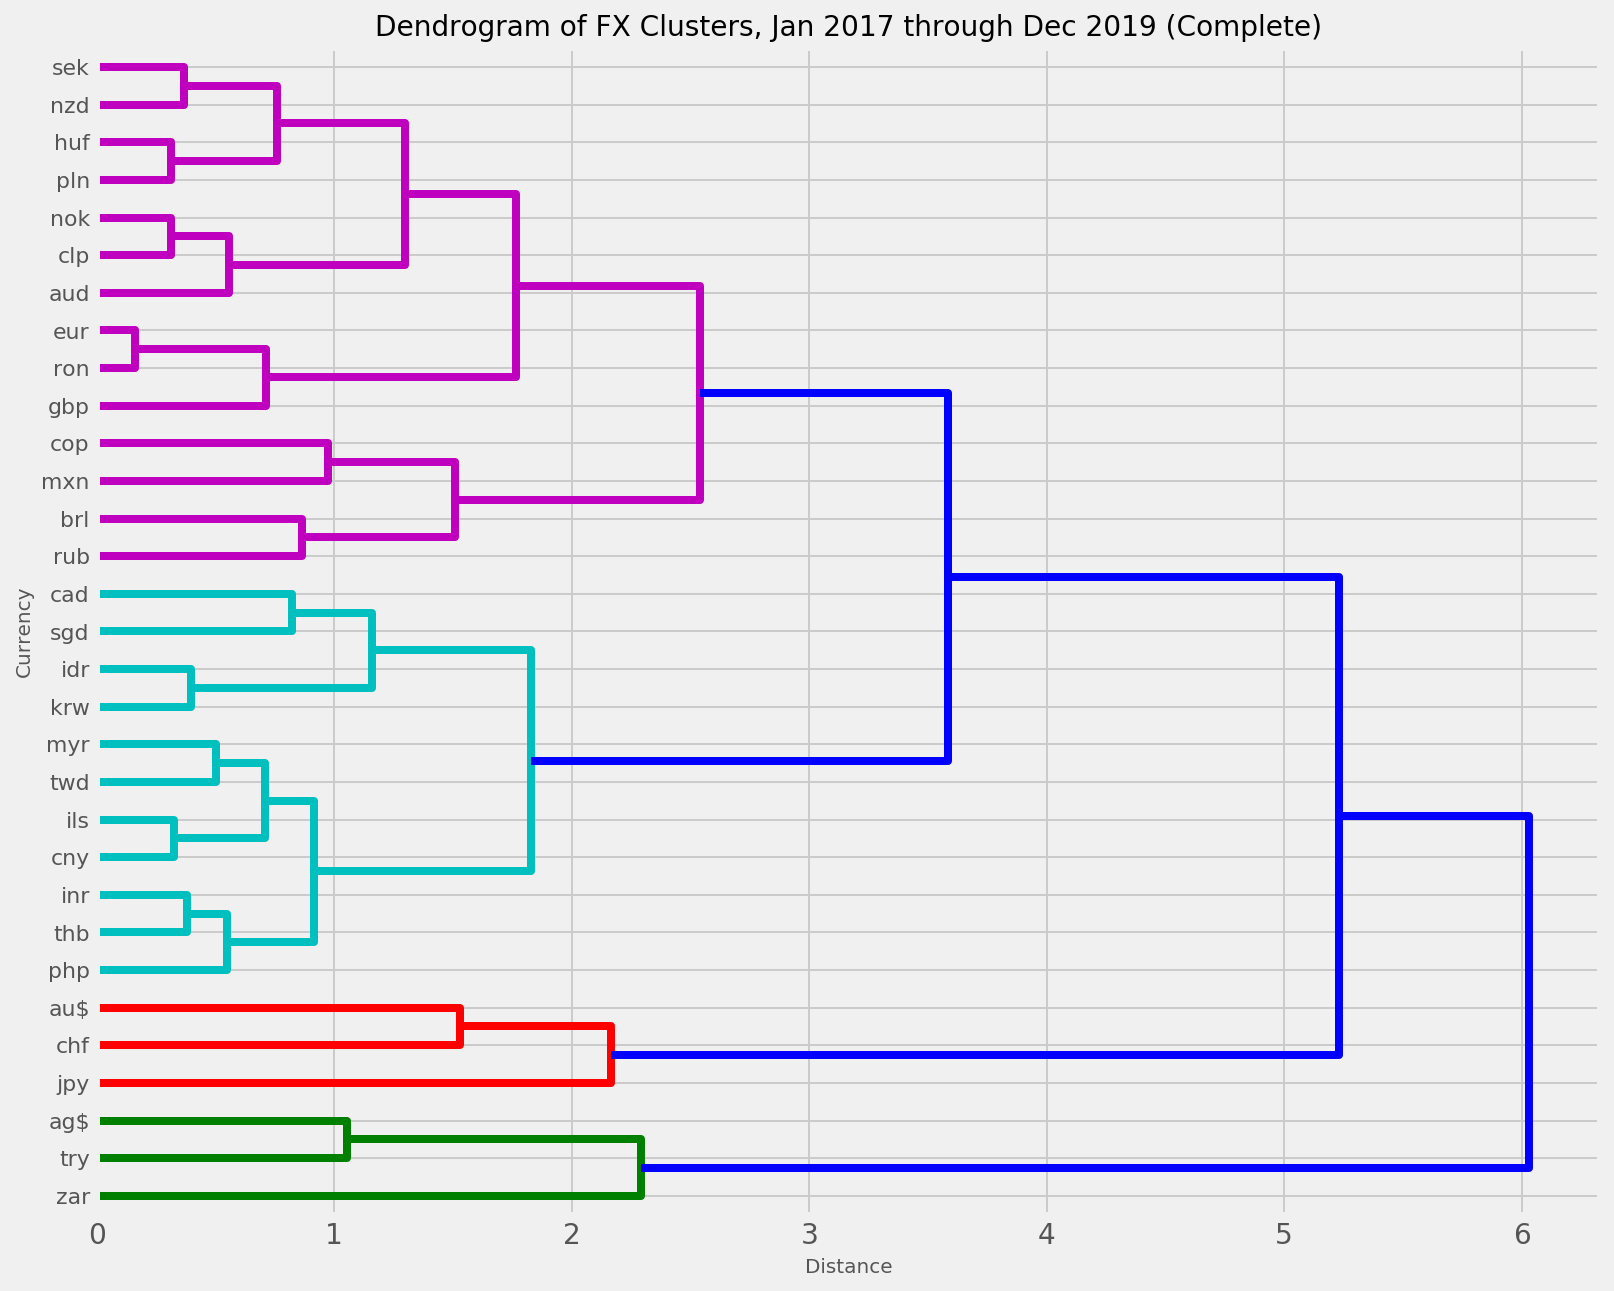

In [60]:
plt.figure(figsize=(12, 10))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Complete)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_comp,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=3
)
plt.yticks(fontsize=11)
plt.show()

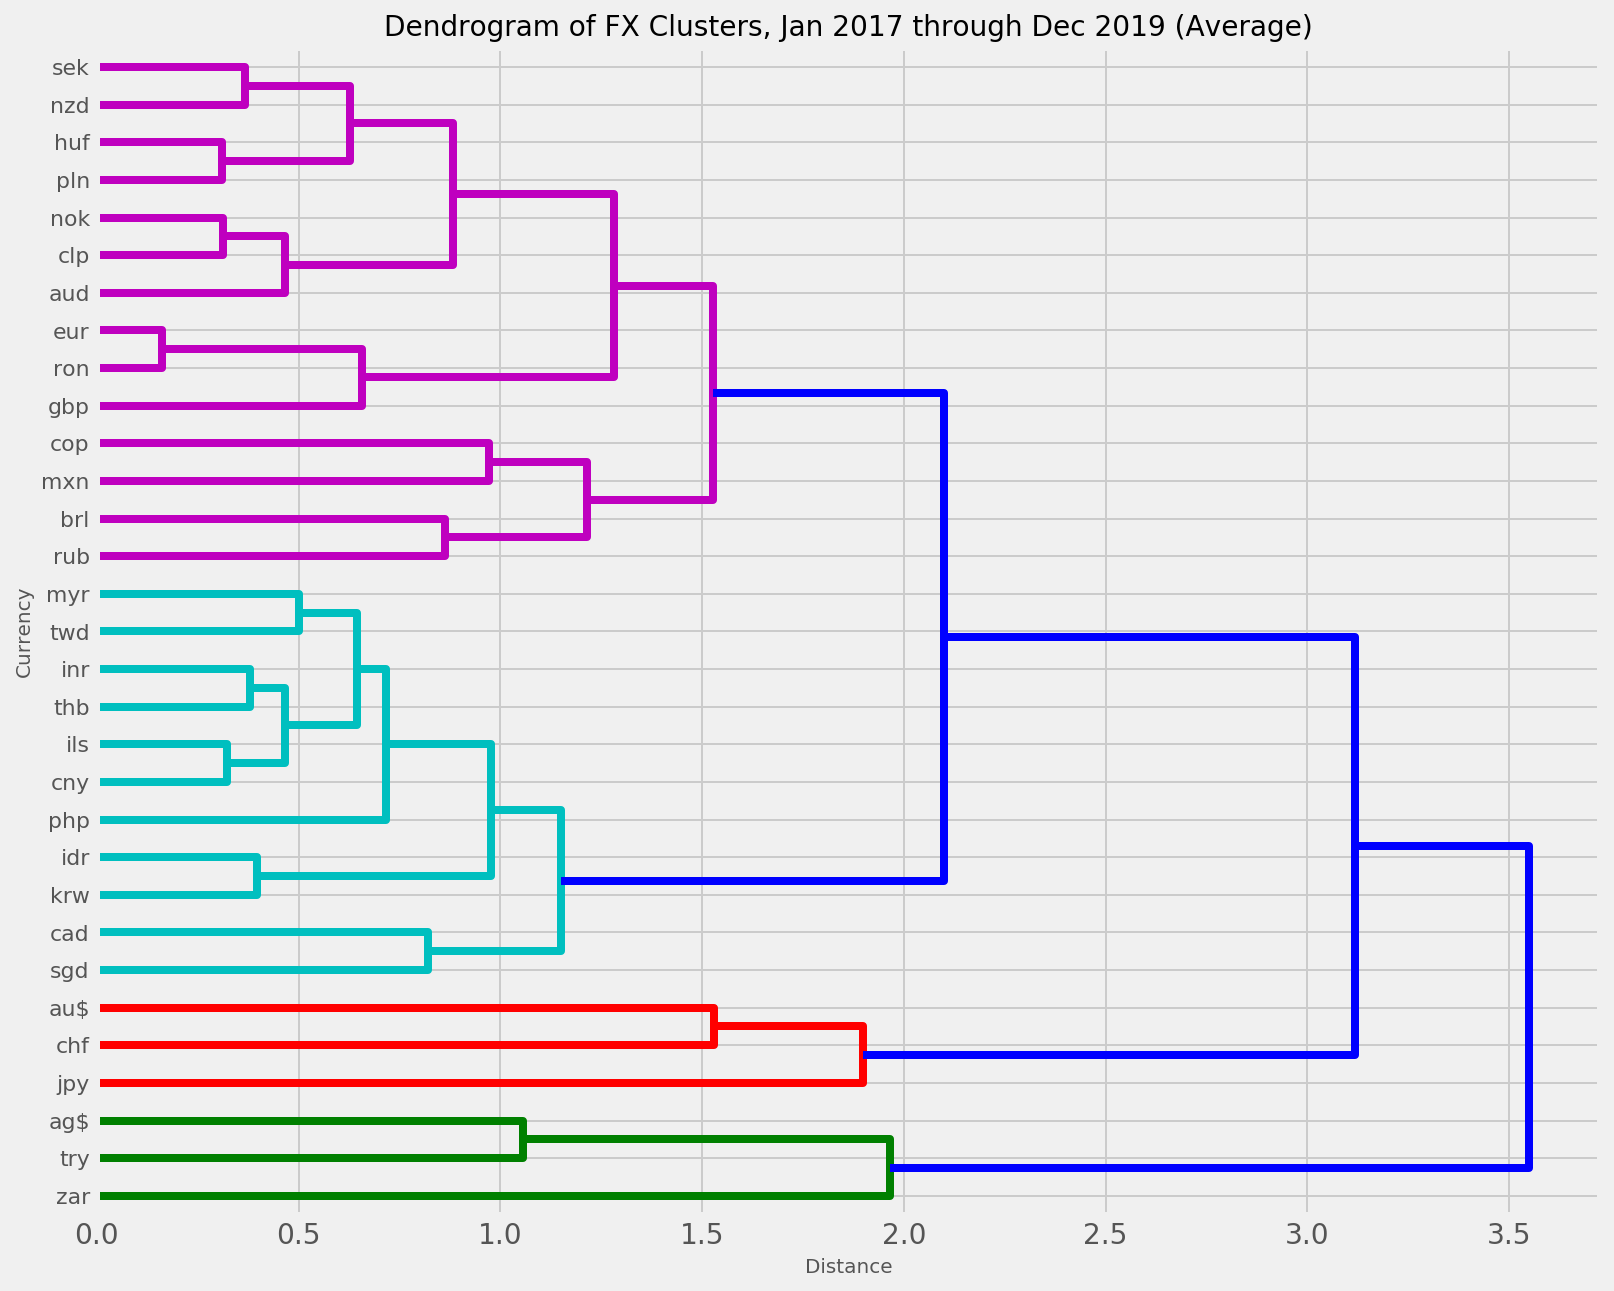

In [61]:
plt.figure(figsize=(12, 10))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Average)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_average,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=2
)
plt.yticks(fontsize=11)
plt.show()

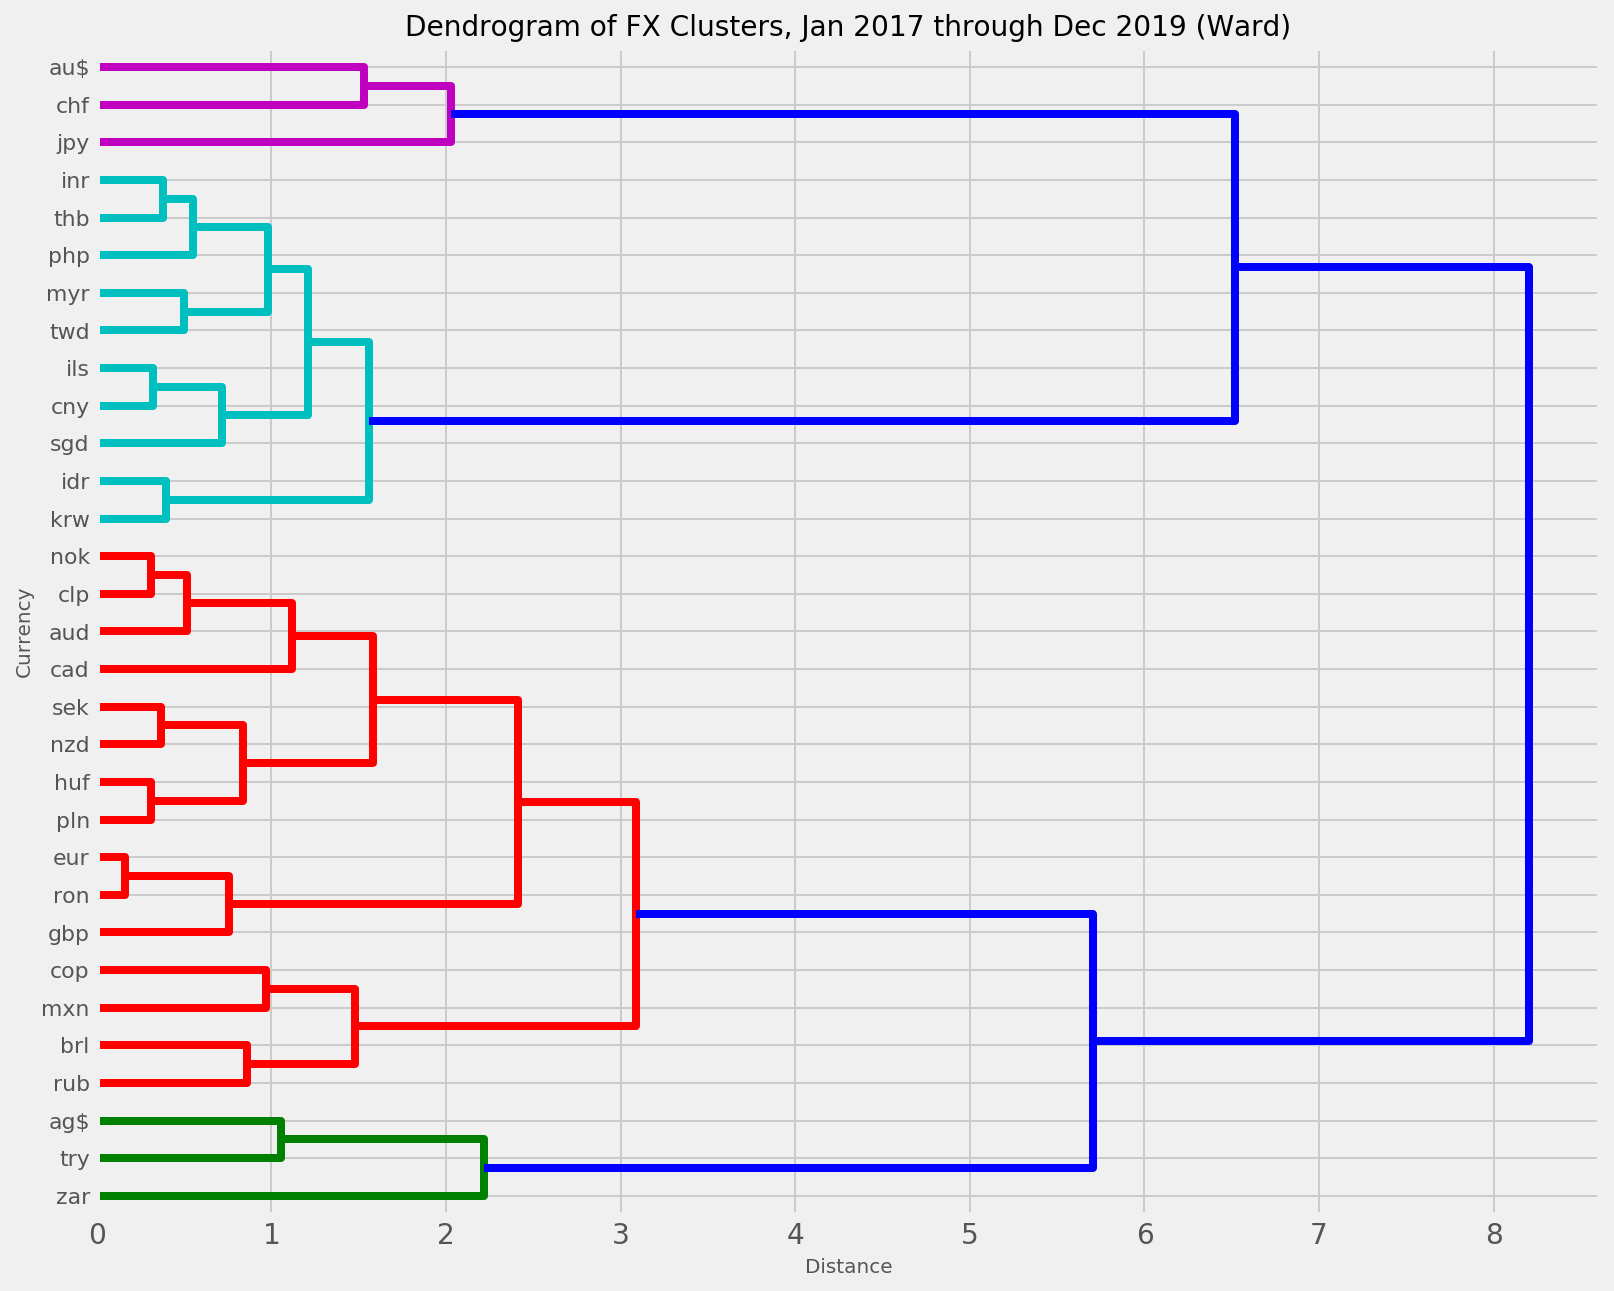

In [62]:
plt.figure(figsize=(12, 10))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Ward)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_ward,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=5
)
plt.yticks(fontsize=11)
plt.show()

#### The various linkages - Complete, Average & Ward - all result in the same final 4 clusters. So no need to go into inter-cluster comparisons with the cophenetic correlations. In any event, the Complete linkage has the best scores among the three. So that's just use that as the final model.

In [63]:
hier_comp = linkage(X_scaled, method='complete', metric='euclidean')
c, coph_dists = cophenet(hier_comp, pdist(X, metric='euclidean'))
c

0.6220473056230421

In [64]:
hier_average = linkage(X_scaled, method='average', metric='euclidean')
c, coph_dists = cophenet(hier_average, pdist(X, metric='euclidean'))
c

0.6154221076785084

In [65]:
hier_ward = linkage(X_scaled, method='ward', metric='euclidean')
c, coph_dists = cophenet(hier_ward, pdist(X, metric='euclidean'))
c

0.3778389554487402

#### The dendrogram (Complete linkage) above shows us how the bottoms-up agglomerative algorithm groups various currencies together during calendar years 2017 through 2019.

#### Four clusters:
#### Cluster 0 - INR, THB, PHP, MYR, TWD, ILS, CNY, SGD, IDR, KRW
#### Cluster 1 - silver, TRY, ZAR
#### Cluster 2 - gold, CHF, JPY
#### Cluster 3 - NOK, CLP, AUD, CAD, SEK, NZD, HUF, PLN, EUR, RON, GBP, COP, MXN, BRL, RUB

#### The closest geographically distinct cluster is Cluster 0 which is composed of mainly Asian currencies

# Cluster Evaluation

In [66]:
# Looks like k=4 gives the best silhouette score
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.431305
3 number of clusters has Silhouette score of 0.409613
4 number of clusters has Silhouette score of 0.433390
5 number of clusters has Silhouette score of 0.368830


In [67]:
# Same when we use Average linkage
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.431305
3 number of clusters has Silhouette score of 0.409613
4 number of clusters has Silhouette score of 0.433390
5 number of clusters has Silhouette score of 0.410441


In [68]:
# Slightly different scores for the Ward linkage, due to the slight difference in results
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.342397
3 number of clusters has Silhouette score of 0.407160
4 number of clusters has Silhouette score of 0.439384
5 number of clusters has Silhouette score of 0.379550


In [69]:
# So we set the AH algorithm with Complete linkage and 4 clusters 
cluster_comp = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  

In [70]:
X['clusters'] = cluster_comp.fit_predict(X_scaled)
X

,usd_beta,equity_corr,vol,clusters
cny,0.558011,-0.286678,5.131818,3
twd,0.257220,-0.310927,5.093537,3
krw,0.545419,-0.348665,8.217590,3
sgd,0.715111,-0.326680,4.431716,3
myr,0.311994,-0.295285,6.743899,3
idr,0.442703,-0.363759,7.122641,3
thb,0.418545,-0.239150,5.130013,3
php,0.248985,-0.193873,5.319555,3
inr,0.464755,-0.212306,6.240227,3
rub,1.063680,-0.321873,11.783409,0


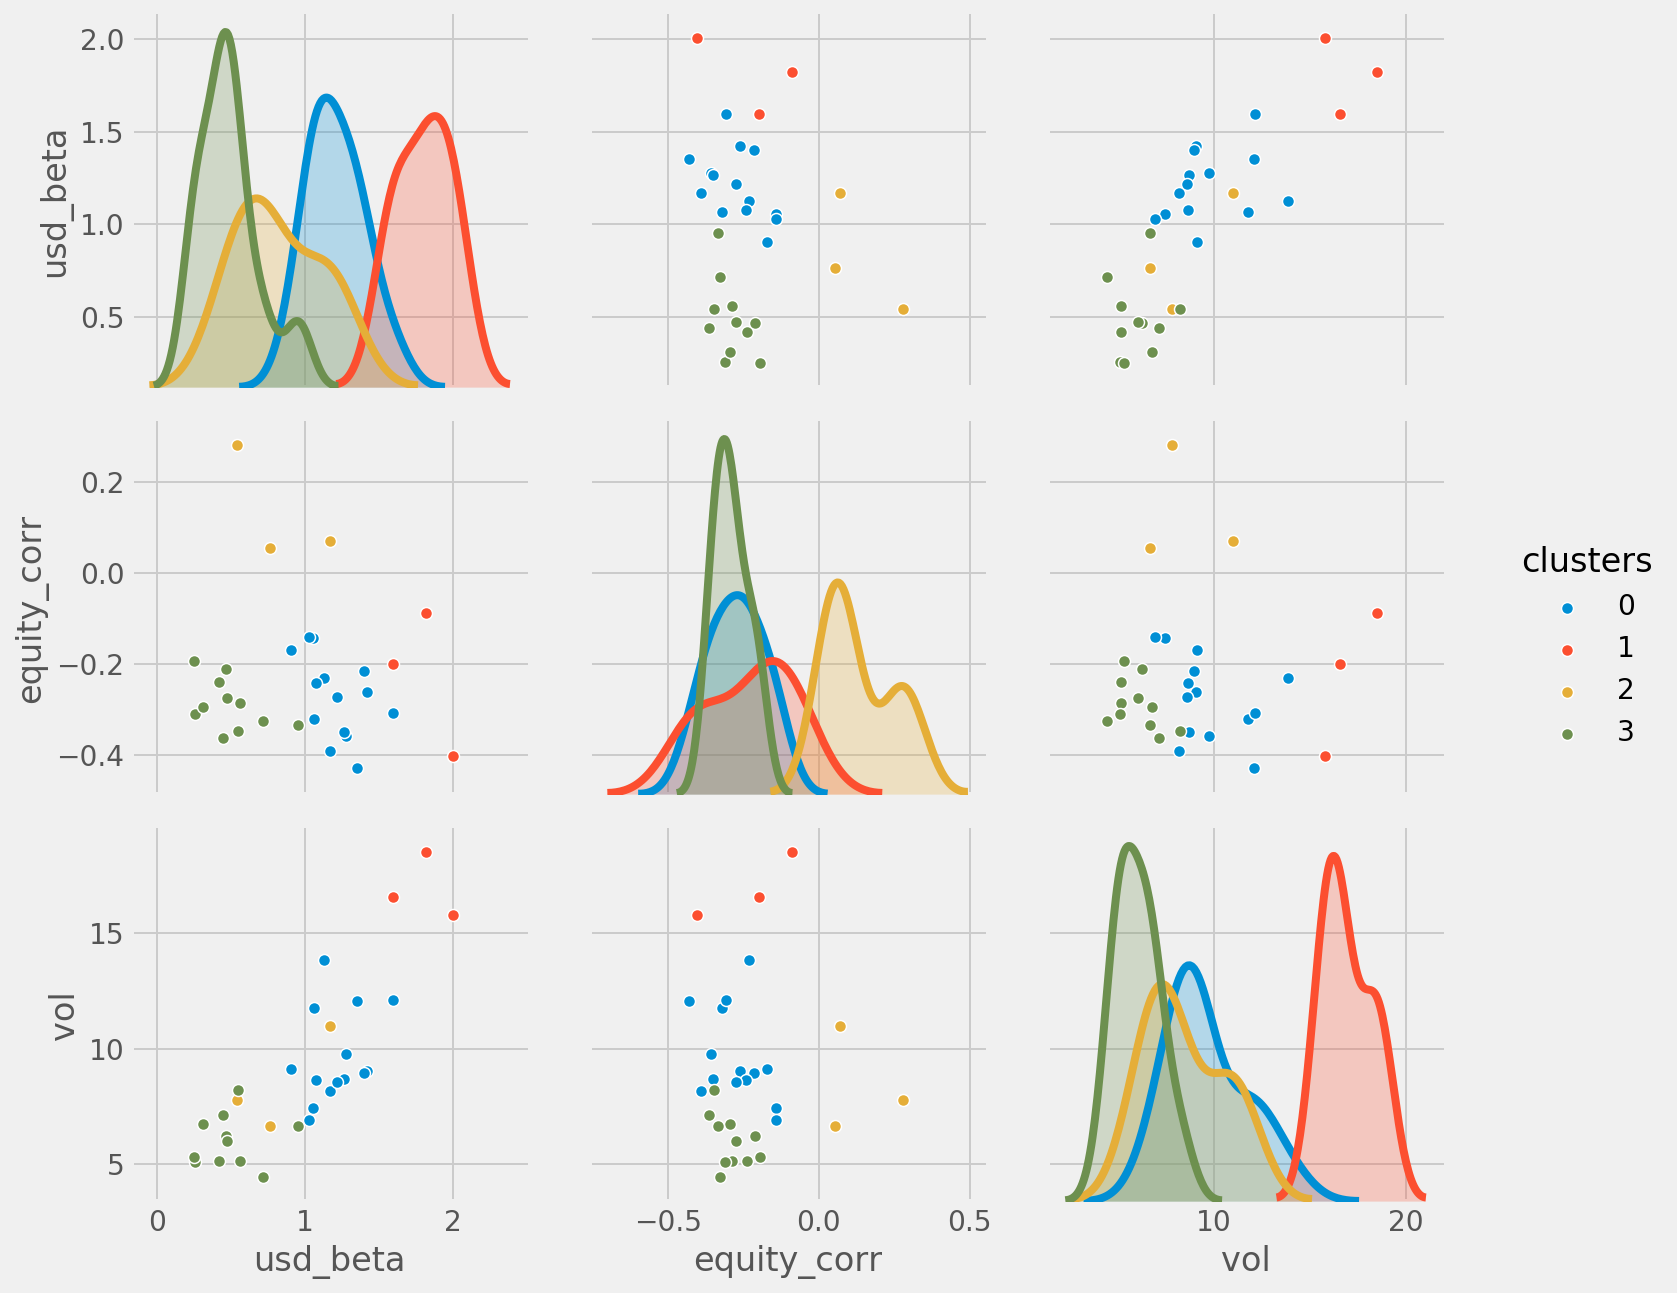

In [71]:
g=sns.pairplot(vars=[col for col in X if col!='clusters'], data=X, hue='clusters')
g.fig.set_size_inches(12,9)
plt.show()

#### The charts above makes clear the distinguishing features of the mainly Asian FX cluster (Cluster 3 - green), which includes ILS and CAD. It has low USD beta and low implied volatility, but a negative equity correlation.

#### This may be contrasted with the "safe haven cluster" (Cluster 2 - yellow), which has a largely similarly low volatility and low USD beta, but is positively correlated to equities (the only cluster to be thus).

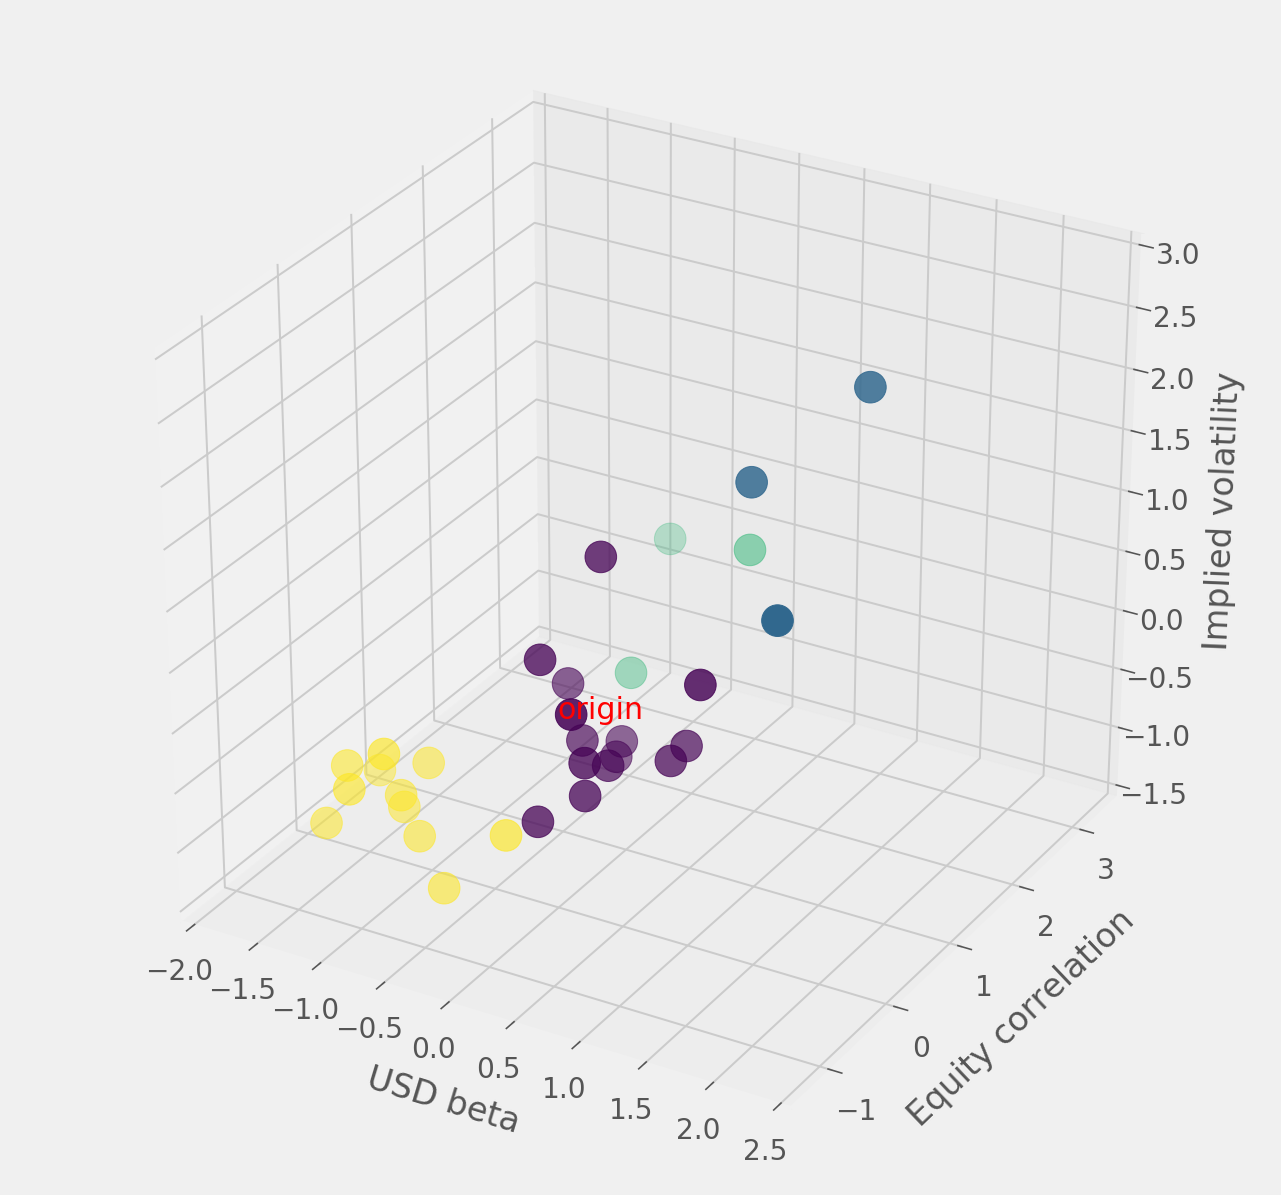

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

origin = [0,0,0]
ax.text(origin[0],origin[0],origin[0],"origin",size=15, color='red')

x_points = X_scaled.usd_beta
y_points = X_scaled.equity_corr
z_points = X_scaled.vol
ax.scatter3D(x_points, y_points, z_points, s=250, c=X.clusters, cmap="viridis")

ax.set_xlim(-2, 2.5)
ax.set_ylim(-1.5, 3.5)
ax.set_zlim(-1.5, 3)

ax.set_xlabel('USD beta',labelpad=10,fontsize='large')
ax.set_ylabel('Equity correlation',labelpad=10,fontsize='large')
ax.set_zlabel('Implied volatility',labelpad=10,fontsize='large')

plt.show()

## Distributional characteristics of each cluster

### Let's evaluate the clusters through boxplots and two sample t-tests

In [73]:
X.groupby('clusters').agg(['mean', 'std', 'count'])

usd_beta                 equity_corr                        vol  \
              mean       std count        mean       std count       mean   
clusters                                                                    
0         1.211009  0.187393    14   -0.273919  0.090343    14   9.650243   
1         1.806500  0.203933     3   -0.229874  0.159604     3  16.955681   
2         0.825627  0.318857     3    0.134313  0.126357     3   8.487346   
3         0.490062  0.206655    11   -0.289678  0.055409    11   6.007915   

                          
               std count  
clusters                  
0         2.014291    14  
1         1.389383     3  
2         2.250620     3  
3         1.115933    11

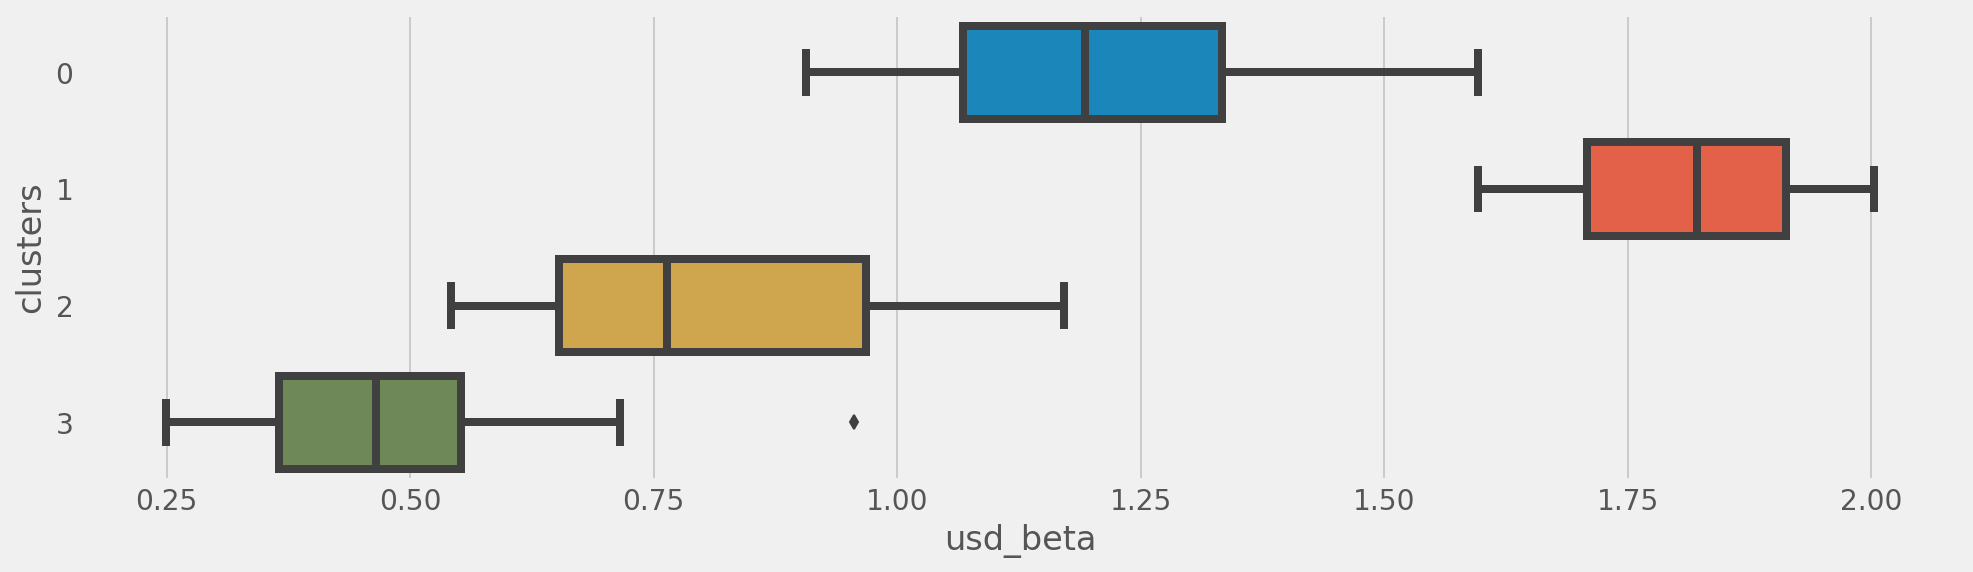

In [74]:
# Box-plots for 'usd_beta'
plt.figure(figsize=(15,4))
sns.boxplot(x='usd_beta', y='clusters', data=X, orient='h');

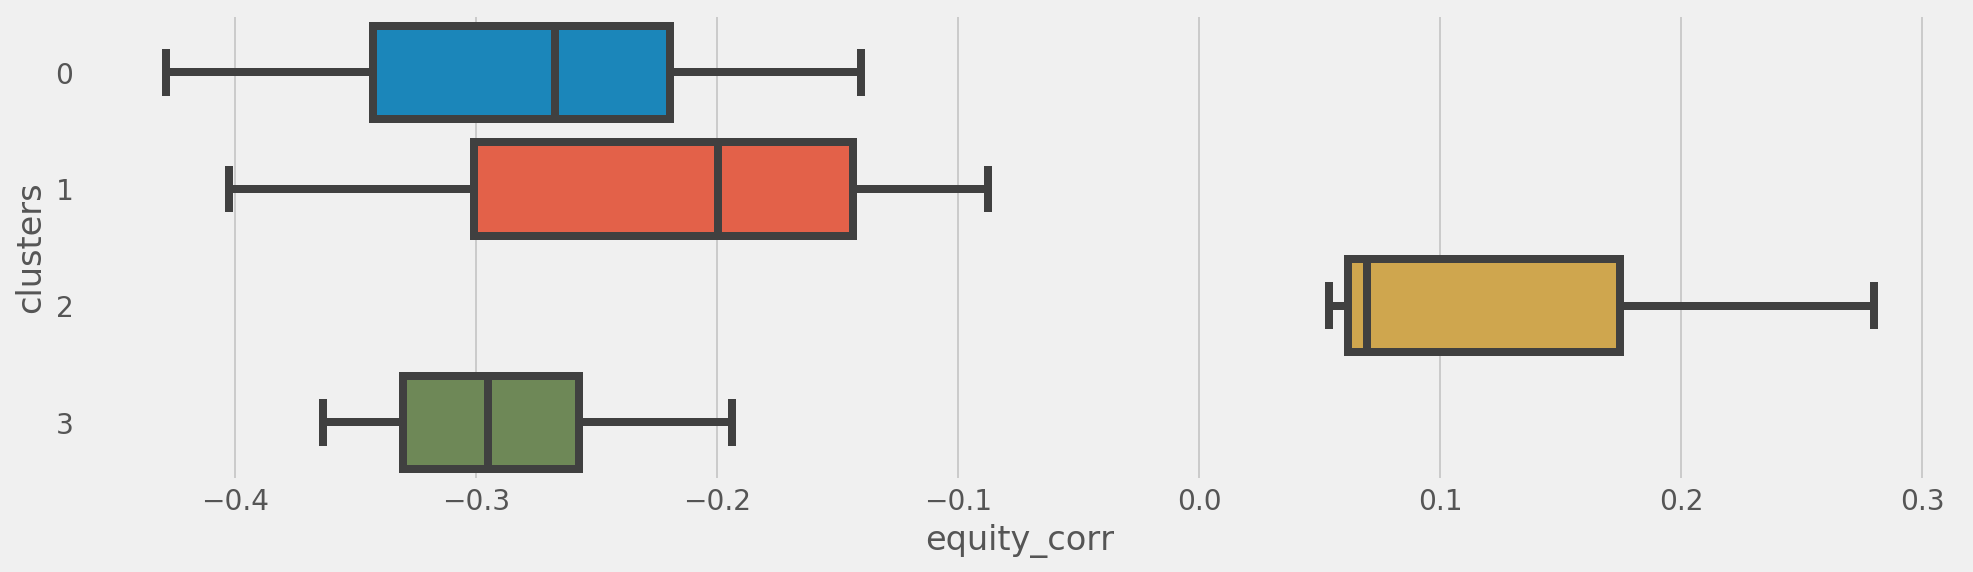

In [75]:
# Box-plots for 'equity_corr'
# Cluster 3 is statistically distinct from the others
plt.figure(figsize=(15,4))
sns.boxplot(x='equity_corr', y='clusters', data=X, orient='h');

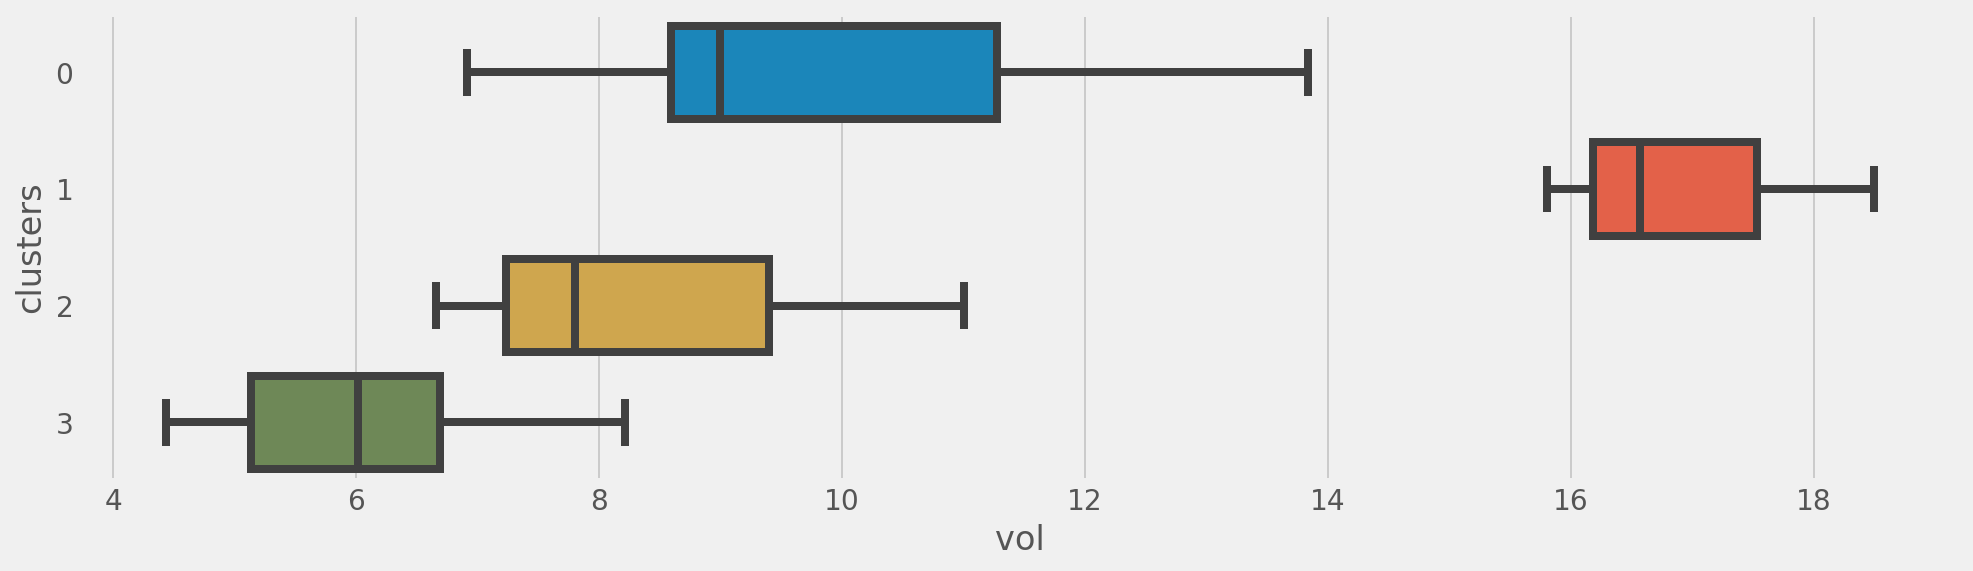

In [76]:
# Box-plots for 'vol'
# Cluster 0, cluster 1 and clusters 2-3 are statistically different from each other
plt.figure(figsize=(15,4))
sns.boxplot(x='vol', y='clusters', data=X, orient='h');

In [77]:
# Function to run t-tests across two feature columns of DataFrame
def cluster_test(i, j):
    column_list = [x for x in X.columns if x != 'clusters']
    t_test_results = {}
    
    for column in column_list:
        group1 = X.where(X.clusters == i).dropna()[column]
        group2 = X.where(X.clusters == j).dropna()[column]

        t_test_results[column] = stats.ttest_ind(group1, group2, equal_var=False)
    
    results_df = pd.DataFrame.from_dict(t_test_results, orient='Index')
    results_df.columns = ['t-statistic','p-value']
    print('Cluster {} versus Cluster {} t-test results:'.format(i, j))
    return results_df


In [78]:
# Cluster 0 is statistically distinct from Cluster 1 in usd_beta and vol
cluster_test(0, 1)

Cluster 0 versus Cluster 1 t-test results:


,t-statistic,p-value
usd_beta,-4.654091,0.022182
equity_corr,-0.462374,0.684203
vol,-7.562088,0.001514


In [79]:
# Cluster 0 is statistically distinct from Cluster 2 in usd_beta and equity_corr
cluster_test(0, 2)

Cluster 0 versus Cluster 2 t-test results:


,t-statistic,p-value
usd_beta,2.019998,0.163668
equity_corr,-5.312451,0.021196
vol,0.826802,0.474320


In [80]:
# Cluster 0 is statistically distinct from Cluster 3 in usd_beta and vol
cluster_test(0, 3)

Cluster 0 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,9.018388,1.405069e-08
equity_corr,0.536752,5.968500e-01
vol,5.737395,1.079562e-05


In [81]:
# Cluster 1 is statistically distinct from Cluster 2 in all three features
cluster_test(1, 2)

Cluster 1 versus Cluster 2 t-test results:


,t-statistic,p-value
usd_beta,4.488623,0.015717
equity_corr,-3.098681,0.038860
vol,5.545540,0.008713


In [82]:
# Cluster 1 is statistically distinct from Cluster 3 in usd_beta and vol
cluster_test(1, 3)

Cluster 1 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,9.882301,0.001610
equity_corr,0.638601,0.584856
vol,12.585540,0.001644


In [83]:
# Cluster 2 is statistically distinct from Cluster 3 in all three features
cluster_test(2, 3)

Cluster 2 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,1.726593,0.201608
equity_corr,5.665233,0.023531
vol,1.847218,0.190423


#### The findings indicate that Cluster 1 (TRY, ZAR & silver) is distinguished by extremely high usd_beta and vol values. 
#### Cluster 2 (JPY, CHF & gold) is distinguished by positive equity_corr values. 
#### Cluster 3 (mostly Asian FX) tends to have the lowest usd_beta and vol values, though with some marginal overlap on these attributes with Cluster 2. 
#### Cluster 4 is the "inbetweener" cluster, particular on usd_beta and vol, with usd_beta values generally higher than 1.0, unlike Clusters 2 and 3.

#### The results show that geography is of little use in segmenting global currencies in terms of their behavior to common financial market factors, except perhaps for non-JPY Asian currencies. The USD beta offered the best differencing factor across the four clusters, followed by implied volatility, and lastly by equity market correlation. However, one cluster ("safe haven cluster") was distinguished by having the only positive equity correlation values.